## Strava Scatterplot

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
strava = pd.read_csv("strava.csv")

Next, we will filter to the workouts that contain only running workouts, and take only the columns that we need for our scatterplot

In [2]:
strava['month'] = pd.DatetimeIndex(strava['timestamp']).month
strava_run = strava[strava['month'] <=8]
strava_scatter = strava_run[['heart_rate', 'datafile', 'altitude','enhanced_speed']]

#drop NaN values
strava_scatter=strava_scatter.dropna(subset= ['heart_rate','altitude'], how = 'any')

Create a new table "alt" that will take the total absolute value of the delta in altitude for each workout

In [3]:
alt=strava_scatter.set_index('datafile').diff()
alt['altitude']=alt['altitude'].abs()
alt=alt.groupby('datafile').altitude.agg('sum').reset_index()
alt.head()

,datafile,altitude
0,activities/2675855419.fit.gz,1115.0
1,activities/2677658978.fit.gz,460.0
2,activities/2677658993.fit.gz,324.0
3,activities/2677659014.fit.gz,259.0
4,activities/2682705331.fit.gz,3323.0


Next, take the average heart rate and speed for each workout, and join that to the alt table we created above.

In [5]:
avg=strava_scatter.groupby('datafile').agg({'enhanced_speed':'mean','heart_rate':'mean'}).reset_index()
combined=alt.set_index('datafile').join(avg.set_index('datafile'))
combined=combined.reset_index()
combined.head()

,datafile,altitude,enhanced_speed,heart_rate
0,activities/2675855419.fit.gz,1115.0,2.108519,118.946502
1,activities/2677658978.fit.gz,460.0,2.618897,122.117647
2,activities/2677658993.fit.gz,324.0,2.683778,135.592593
3,activities/2677659014.fit.gz,259.0,2.437679,134.571429
4,activities/2682705331.fit.gz,3323.0,1.966212,117.687157


Now that the data is cleaned and prepped, we can begin the scatterplot

In [6]:
fig = go.Figure(data=go.Scatter(x=combined['enhanced_speed'], ##speed on the x axis
                                y=combined['heart_rate'], ##heart rate on the y axis
                                mode='markers', ##set mode to individual markers for each value pair
                                marker_color=combined['altitude'], ##color for each pair will be the value of its total change in altitude
                                marker=dict(size=16, colorscale = 'Viridis', showscale=True),
                                text = combined['datafile'], ##hovering over each point will show you which workout ID it was
                               )) 

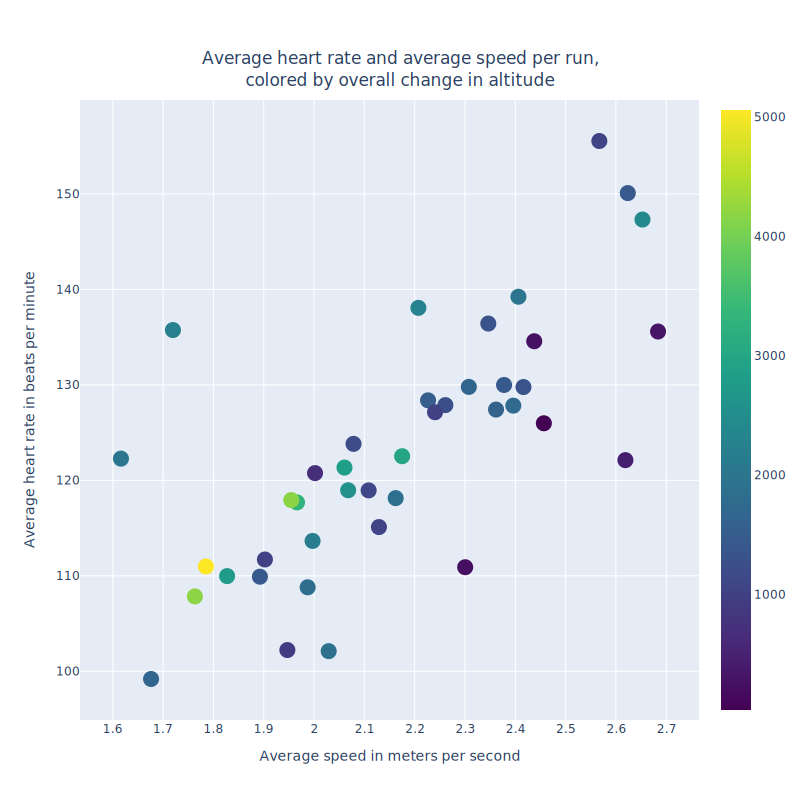

In [9]:
fig.update_layout(
        title={
        'text': "Average heart rate and average speed per run, <br>colored by overall change in altitude",
        'y':0.92, #set the location of the title, and anchor points
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    
        xaxis_title="Average speed in meters per second", #set axis titles
        yaxis_title="Average heart rate in beats per minute",
        width = 800, height = 800, #set figure size

        xaxis = dict( #customize ticks for the x axis
        tickmode = 'linear',
        tick0 = 1.6,
        dtick = 0.1
    )

)
fig.show("svg")

The scatterplot is able to show us some meaningful information about the client's running workouts. There seems to be a moderately positive correlation between the average speed of the workout and the average heart rate for each workout. The faster the client ran, the higher their heart rate was on average. There didn't seem to be a meaningful interaction with changes in altitude, however. I would have suspected that a workout with a high change in altitude would be more difficult, and possibly having a negative correlation with average speed, and a positive correlation with average heart rate, but neither seem to be true. There is a chance that a change in altitude was compensated for, perhaps by taking a slower pace, or maybe workouts that included large changes in altitude were shorter in distance.